In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patheffects
import matplotlib as mpl
import numpy as np
import pandas as pd
import vice

from surp.analysis.apogee_analysis import subgiants
import seaborn as sns
from surp.analysis import plotting_utils as pluto

from surp._globals import AGB_MODELS
import arya
import scipy

using vice version  1.4.0.dev1


In [3]:
plt.rcParams["savefig.directory"] = "figures"


In [4]:
def cooh_data(ax=None, **params):
    
    ha = subgiants["high_alpha"]
    df = subgiants[~ha]
    
    arya.binnedplot(df, x="MG_H", y="C_MG", binrange=(-0.5, 0.5), binwidth=0.05,
                              cmin=1, stat="median", errorbar="pi",   **params)
    
def coofe_data(o_0=-0.1, w=0.05, ax=None, **kwargs):

        
    filt = subgiants["MG_H"] > o_0 - w
    filt &= subgiants["MG_H"] < o_0 + w
    df = subgiants[filt]
    arya.binnedplot(df, x="MG_FE", y="C_MG", binrange=(-0.1, 0.5),
                              cmin=1, stat="median", errorbar="pi",   **params)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(7, 10/3), sharey=True, gridspec_kw={"wspace": 0})

plt.sca(axs[0])
sns.scatterplot(subgiants, x="MG_H", y="C_MG", hue="high_alpha", s=1, ec="none")
L = arya.Legend(labels=[r"low $\alpha$", r"high $\alpha$"], color_only=True, loc=4)
for text in L.mpl_leg.get_texts():
    text.set_path_effects([mpl.patheffects.Stroke(linewidth=3, foreground='w'),
                       mpl.patheffects.Normal()])
    
plt.ylabel("[C/Mg]")
plt.xlabel("[Mg/H]")
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.1)

plt.sca(axs[1])
sns.scatterplot(subgiants, x="MG_FE", y="C_MG", hue="MG_H", s=1, legend=False, hue_norm=(-0.5, 0.5), palette=plt.get_cmap(), ec="none")
plt.xlim(-0.1, 0.5)
plt.xticks(np.arange(0, 0.51, 0.1))

plt.xlabel("[Mg/Fe]")

cax = axs[1].inset_axes([1.05, 0., 0.05, 1])

arya.Colorbar(clim=(-0.5, 0.5), label="[Mg/H]", cax=cax)
plt.savefig("subgiants.pdf")

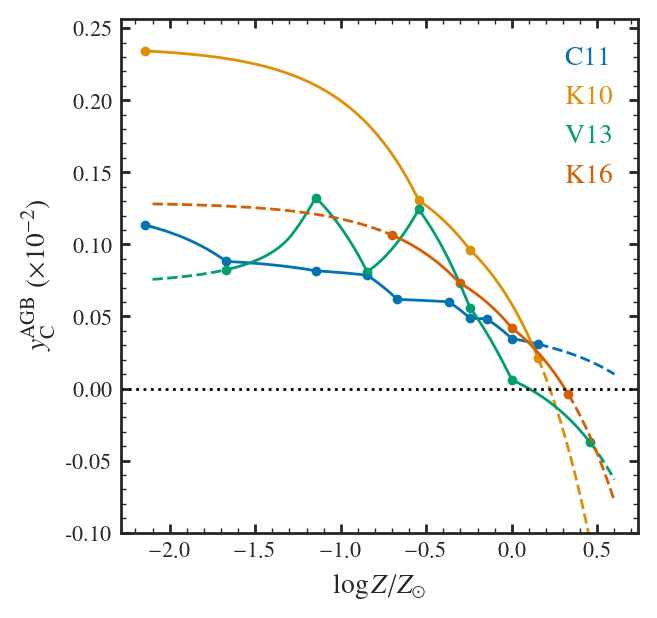

In [6]:
plt.figure(figsize=(10/3, 10/3))

for i in range(len(AGB_MODELS)):
    model = AGB_MODELS[i]

    vice.yields.agb.settings["c"] = model
    vice.yields.ccsne.settings["c"] = 0
    Zs = 0.014*10**np.linspace(-2, 1, 100)
    
    # plots importaint points
    if type(model) == str:
        y1, m1, z1 = vice.yields.agb.grid('c', study=model)
        Zs = np.array(z1)
    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])
        
    y_c_agb = np.array(mass_yields)/1e6 
    y_o_cc = 0.015
    plt.scatter(np.log10(Zs/0.014), y_c_agb)
    MoverH_min = np.log10(min(Zs)/0.014)
    MoverH_max = np.log10(max(Zs)/0.014)
    
    Zs = 0.014*10**np.linspace(MoverH_min, MoverH_max, 100)
    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])
    line, = plt.plot(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), label=["C11", "K10", "V13", "K16"][i])

    color = line.get_color()

    Zs = 0.014*10**np.linspace(-2.1, MoverH_min, 100)
    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])
    plt.plot(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), linestyle="--", color=color)

    Zs = 0.014*10**np.linspace(MoverH_max, 0.6, 100)
    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])
    plt.plot(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), linestyle="--", color=color)

plt.axhline(0, color="k", ls=":")
plt.xlabel(r"$\log Z/Z_\odot$")
plt.ylabel(r"$y_{\rm C}^{\rm AGB}$ ($\times10^{-2}$)")

plt.ylim(-0.001)
prop_cycle = plt.rcParams['axes.prop_cycle']

arya.Legend(color_only=True, handlelength=0)
xs= np.arange(-0.001, 0.0026, 0.0005)
plt.yticks(xs, labels=["%0.2f" % a for a in 100*xs])

plt.savefig("y_agb_vs_z.pdf")

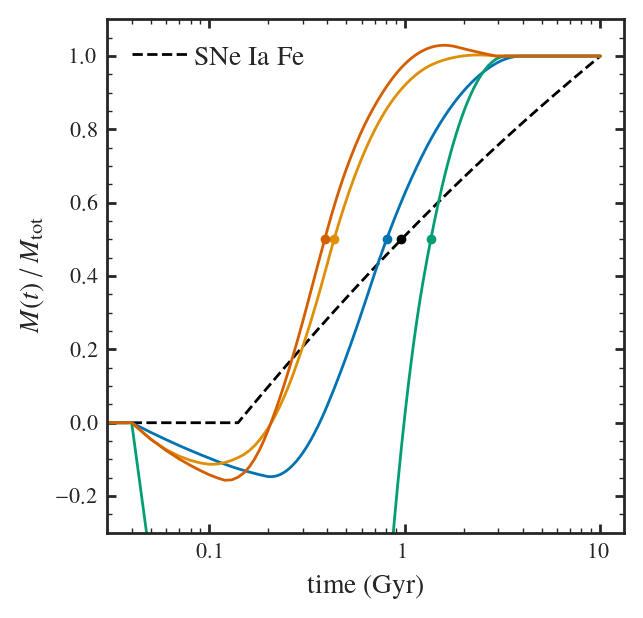

In [7]:
plt.figure(figsize=(10/3, 10/3))

vice.yields.ccsne.settings["c"] = 0
vice.yields.sneia.settings["c"] = 0
vice.yields.ccsne.settings["fe"] = 0

for i in range(4):
    model = AGB_MODELS[i]
    vice.yields.agb.settings["c"] = model
    m_c, times = vice.single_stellar_population("c", Z=0.014 * 10**0, dt=0.01)
    y = np.array(m_c)/m_c[-1]
    plt.plot(times, y)
    
    f = scipy.interpolate.interp1d(y, times)
    plt.scatter(f(0.5), 0.5)
    

m_fe, times = vice.single_stellar_population("fe", Z=0.014)
y = np.array(m_fe)/m_fe[-1]
plt.plot(times, y, label="SNe Ia Fe",
         linestyle="--", color="k", zorder=-1)
f = scipy.interpolate.interp1d(y, times)
plt.scatter(f(0.5), 0.5, color="k")


plt.xlabel(r"time (Gyr)")
plt.ylabel(r"$M(t)\,/\,M_{\rm tot}$")
plt.xscale("log")
plt.legend()
plt.ylim(-0.3, 1.1)
plt.xlim(0.03, 13.2)
plt.xticks([0.1, 1, 10], labels=[0.1, 1, 10])

plt.savefig("y_agb_vs_t.pdf")

In [24]:
arya.style.set_fontsize(10)

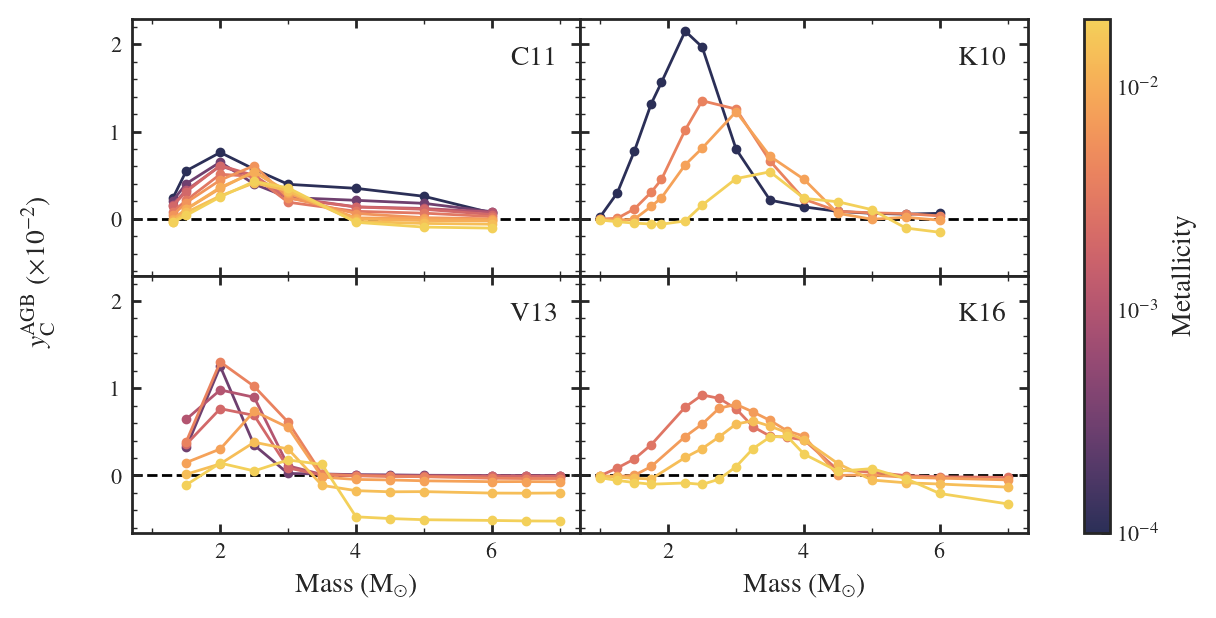

In [48]:

Z_max = 0.02
Z_min = 0.0001
AGB_LABELS = ["C11", "K10", "V13", "K16"]

hmap = arya.figure.colorbar.HueMap((Z_min, Z_max), norm="log")

def plot_c_table(study = "cristallo11", ax=None, fig=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()

    y1, m1, z1 = vice.yields.agb.grid('c', study=study)
    N = len(z1)

    for i in range(N):
        y = 100*np.array(y1)[:,i]
        z = z1[i]
        c = hmap(z)
        f = ax.plot(m1, y, "o", label=f"Z = {z}", c=(c), **kwargs)
        f = ax.plot(m1, y, label=f"Z = {z}", c=(c), **kwargs)
        # ax.set_xticks(np.arange(1, 8))
    
    ax.axhline(0, color="k", ls="--", zorder=-1)

    return f


fig, axs = plt.subplots(2, 2, figsize=(7, 10/3), sharex=True, sharey=True, gridspec_kw={"hspace":0, "wspace": 0, "left": 0.1})
# plt.minorticks_off()

for i in range(4):
    study = AGB_MODELS[i]
    label = AGB_LABELS[i]
    ax = axs[i//2][i%2]
    f = plot_c_table(study, ax=ax, fig=fig)
    ax.text(0.95, 0.9, label, horizontalalignment='right',
            verticalalignment='top', transform=ax.transAxes)
    #plt.legend()
    # ax.tick_params(
    #         length=5
    #         )



arya.Colorbar(huemap=hmap, ax=axs.ravel().tolist(), label=r"Metallicity")

plt.setp(axs[-1, :], xlabel=r'Mass (${\rm M}_\odot$)')
fig.supylabel(r'$y_{\rm C}^{\rm AGB}\ (\times10^{-2})$')

plt.gca().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))

plt.savefig("agb_yields.pdf")

In [18]:
# some studies have -inf values, which are ignored
allowed_MoverH = {
    "LC18": [-3, -2, -1, 0],
    "S16/N20": [0],
    "S16/W18": [0],
    "S16/W18F": [0],
    #"CL13": [0],
    "NKT13": [-np.inf, -1.15, -0.54, -0.24, 0.15, 0.55],
    #"CL04": [-np.inf, -4, -2, -1, -0.37, 0.15],
    "WW95": [-np.inf, -4, -2, -1, 0]
    }

M_max = {
    "LC18": 120,
    "S16/N20": 120,
    "S16/W18": 120,
    "S16/W18F": 120,
    "NKT13": 40,
    "WW95": 40,
    "CL04": 35,
    "CL13": 120,
}

ccsne_studies = ["LC18", "LC18", "S16/W18F", "S16/W18", "NKT13", "WW95"]
colors = [arya.style.COLORS[i] for i in [0,0,1,1,2,3,4]]
markers = ["o", "o", "s", "d", "*", "^"]
sizes = [30, 30,30, 30,30,30]
rotations = [0, 300, 0, 0, 0, 0]
N = len(ccsne_studies)

labels = [r"LC18, $v_{\rm rot}=0\;{\rm km\,s^{-1}}$", 
          r"LC18, $v_{\rm rot}=300\;{\rm km\,s^{-1}}$",
          "S16/All explode", 
          "S16/W18", 
          "NKT13", 
          "WW95"]


def plot_analy():
    m_h = np.linspace(-0.6, 0.5, 1000)
    Z = 0.014*10**m_h
    plt.plot(m_h, y_c_cc(Z), color="k")
    
    m_h = np.linspace(-4, -0.6, 1000)
    Z = 0.014*10**m_h
    plt.plot(m_h, y_c_cc(Z), color="k", ls="-", zorder=-2, label="Analytic")

    
def plot_c11():
    vice.yields.agb.settings["c"] = "cristallo11"
    vice.yields.ccsne.settings["c"] = 0
    Zs = 0.014*10**np.linspace(-2, 1, 100)

    MoverH_min = np.log10(min(Zs)/0.014)
    MoverH_max = np.log10(max(Zs)/0.014)

    Zs = 0.014*10**np.linspace(MoverH_min, MoverH_max, 100)
    mass_yields = []
    for Z in Zs:
        m_c, times = vice.single_stellar_population("c", Z=Z)
        mass_yields.append(m_c[-1])
    line, = plt.plot(np.log10(Zs/0.014), (np.array(mass_yields)/1e6 ), label="C11 (AGB)", color=colors[-1])



In [19]:
def plot_y_cc(ele='c', ele2=None):
    for i in range(N):
        study=ccsne_studies[i]
        metalicities = allowed_MoverH[study]
        m_upper = M_max[study]

        rotation = rotations[i]

        y = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metalicity, 
            rotation=rotation, m_upper=m_upper)[0]
             for metalicity in metalicities]
        if ele2 is not None:
            y2 = np.array([vice.yields.ccsne.fractional(ele2, study=study, MoverH=metalicity, 
                rotation=rotation, m_upper=m_upper)[0]
                 for metalicity in metalicities])
            y = np.log10(y/y2) - np.log10(vice.solar_z(ele)/vice.solar_z(ele2))

        marker = markers[i]
        color =facecolor= colors[i]
        label = labels[i]
        if np.isinf(metalicities[0]):
            if study == "WW95":
                x0 = -4.5
                y0 = -0.000
                ms = 5
                zorder = 2
            else:
                x0 = -4.5
                y0 = 0
                ms = 6
                zorder = 3
            plt.errorbar(x0, y[0] + y0, xerr=[0.2], fmt=marker, color=color, 
                         xuplims=[1],ms=ms, zorder=zorder, capsize=0)
            x = metalicities[1:]
            y = y[1:]
        else:
            x = metalicities

        if rotation == 150:
            facecolor=(1,1,1,0)
        if rotation == 300:
            facecolor=(1,1,1,0)

        plt.scatter(x, y, ec=color, label=label,
                    lw=1, fc=facecolor, 
                     marker=marker, s=sizes[i])


In [20]:
def y_c_cc(Z):
    return 0.0028 + 0.001*Z/0.014

/tmp/slurmtmp.17178001/ipykernel_137590/804337447.py:9: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y = [vice.yields.ccsne.fractional(ele, study=study, MoverH=metalicity,
/tmp/slurmtmp.17178001/ipykernel_137590/804337447.py:13: ScienceWarning: Woosley & Weaver (1995) did not report their birth abundances. VICE cannot compute net yields for this study, only reporting gross yields.
  y2 = np.array([vice.yields.ccsne.fractional(ele2, study=study, MoverH=metalicity,


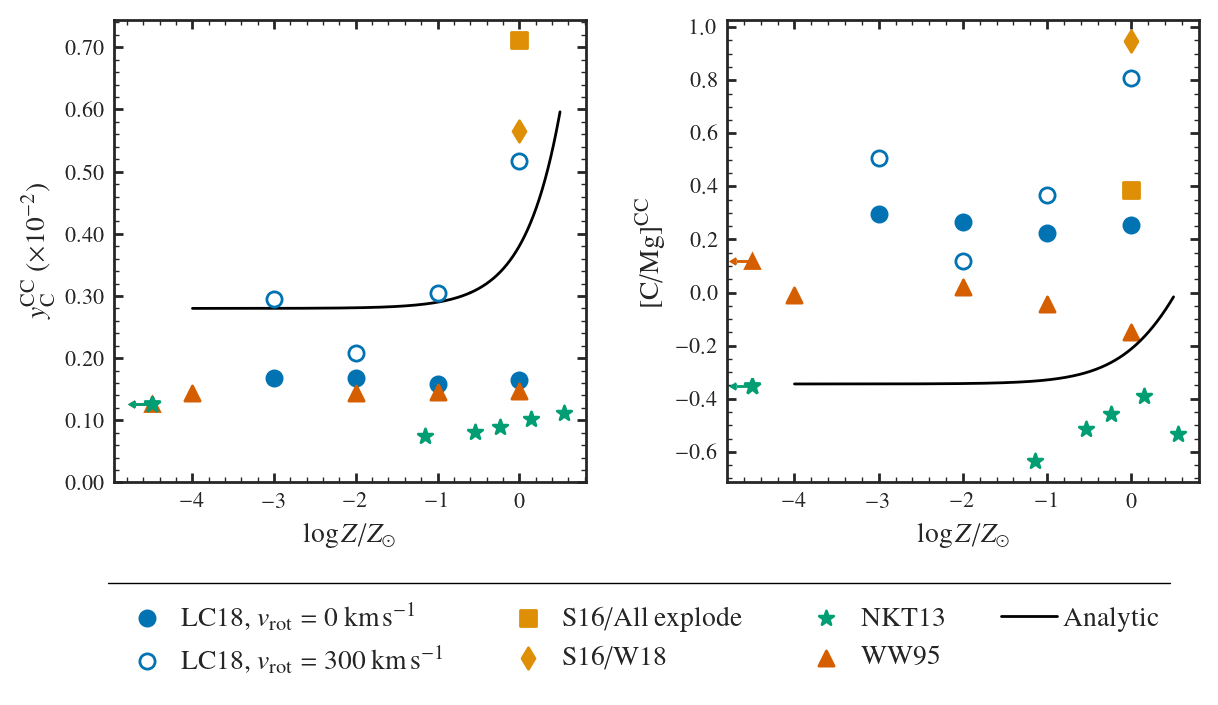

In [121]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3), gridspec_kw={"wspace": 0.3})

plt.sca(axs[0])


plot_y_cc()

plot_analy()
# plot AGB line
plt.xlabel(r"$\log Z/Z_{\odot}$")
plt.ylabel(r"$y_{\rm C}^{\rm CC}~(\times10^{-2})$")

plt.ylim(0)



lines, labels = axs[0].get_legend_handles_labels()

    

xs = np.arange(0.00, 0.008, 0.001)
plt.yticks(xs, labels=["%0.2f" % a for a in 100*xs])



plt.sca(axs[1])

plot_y_cc(ele2="mg")


m_h = np.linspace(-4, 0.5, 1000)
Z = 0.014*10**m_h
y = np.log10(y_c_cc(Z)/0.015) - np.log10(vice.solar_z("c")/vice.solar_z("o"))
plt.plot(m_h, y, color="k")


# final style things
lab = plt.xlabel(r"$\log Z/Z_{\odot}$")
plt.ylabel(r"[C/Mg]$^\text{CC}$")
plt.xlim(-4.8, 0.8)



    
leg = fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, -0.05), ncols=4)
box1 = leg.get_tightbbox()
box2 = lab.get_tightbbox() 


t1 = box1.transformed(fig.transFigure.inverted())
t2 = box2.transformed(fig.transFigure.inverted())
ym = (t2.y0 + t1.y1)/2


# plt.legend(handles =l, bbox_to_anchor=(0,-0.2), loc="upper left")
fig.add_artist(mpl.lines.Line2D([t1.x0, t1.x1], [ym, ym], color="k", lw=0.5))

plt.savefig("cc_yields.pdf")